In [1]:
import json
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from typing import Union, Iterable
from collections import Counter 



In [2]:
# load historic data
data = pd.read_csv('../data/twitter/pyhon_tweets_fairdata.csv', dtype={'Content': str})
print(data)
print(data.shape)



                           Data                   ID  \
0     2023-03-28 10:54:07+00:00  1640668586736795649   
1     2023-03-28 10:52:12+00:00  1640668101200027648   
2     2023-03-28 10:37:03+00:00  1640664290452447237   
3     2023-03-28 10:00:53+00:00  1640655186694643712   
4     2023-03-28 09:48:14+00:00  1640652006120386560   
...                         ...                  ...   
997   2022-12-09 07:49:03+00:00  1601121735495286784   
998   2022-12-09 07:15:00+00:00  1601113164170469377   
999   2022-12-08 22:03:54+00:00  1600974476996665345   
1000  2022-12-08 18:25:50+00:00  1600919599897530369   
1001  2022-12-08 16:24:48+00:00  1600889140983123974   

                                                Content         Username  \
0     @wilhwid @BBMRIERIC @ilireh @ECRIN_ERIC @tugra...  eoscassociation   
1     I spent this morning with @EeroRinne and the s...  LukeDataManager   
2     The first panel at today's #EOSCTripartite eve...  eoscassociation   
3     💰That's right! We

## Functions

In [3]:
def findMeta(s: str, meta: Union[str, Iterable] = ["@", "#"]) -> dict:
    """Find all metatags in a string and return a set of these metatags."""
    meta = [meta] if isinstance(meta, str) else meta
    return {k: {w for w in s.split(" ") if w.startswith(k)} for k in meta}


def addFollower(graph: nx.Graph, follower: str, mentions: Iterable = []) -> None:
    """Add follower with edges to their mentions."""
    # TODO: check if new nodes with edges to existing nodes overwrite their connections.
    if ((follower != "") or (follower is not None)):
        mentions = [mentions] if isinstance(mentions, str) else mentions
        follower = "@" + follower if not follower.startswith("@") else follower
        if len(mentions):
            graph.add_edges_from(((follower, e) for e in mentions)) # generator expression whoo
        else:
            graph.add_node(follower)

            
def inMostCommon(tags: Iterable, most_common: Iterable) -> bool:
    """Check if at least one of the metatags exists in the most common metatags."""
    for t in tags:
        if t in most_common:
            return True
    return False


def occuranceCounter(ContentList: list, mostCommon: int = 10) -> tuple:
    """Returns the labels and the counts of the most common elements in `contentList`.
    Any negative value for `mostCommon` will return the full list.  
    Assumes that `contentList` is sorted.
    
    Return is a tuple of the sorted label and the sorted value list. For the full list a numpy array is created
    """
    if mostCommon > 0:
        return zip(*dict(Counter(ContentList).most_common(mostCommon)).items())
    else:  # numpy
        labels, values = zip(*dict(Counter(ContentList)).items())
        sort = np.argsort(values)[::-1]  # descending order 
        return np.array(labels)[sort], np.array(values)[sort]

## Network

In [30]:
# init graph
twitterGraph = nx.Graph()

# find most common hashtags and mentions
mostCommontwitter = 10  # arbitrary
hashtagstwitter = []  # init
mentionstwitter = []  # init

for l in data.Content:
    metas = findMeta(str(l))
    hashtagstwitter.extend(metas['#'])
    mentionstwitter.extend(metas['@'])

hashtagstwitter = sorted(hashtagstwitter)
mentionstwitter = sorted(mentionstwitter)

hashLabels, hashValues = occuranceCounter(hashtagstwitter)
mentLabelsTwitter, mentValuesTwitter = occuranceCounter(mentionstwitter)

1) Investigating most common mentions

/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_58156/2411285489.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  yticks = ax.set_yticklabels(mentLabels[::-1], fontdict={'fontsize': 14})


Text(0.5, 0, '$\\#$ of mentions')

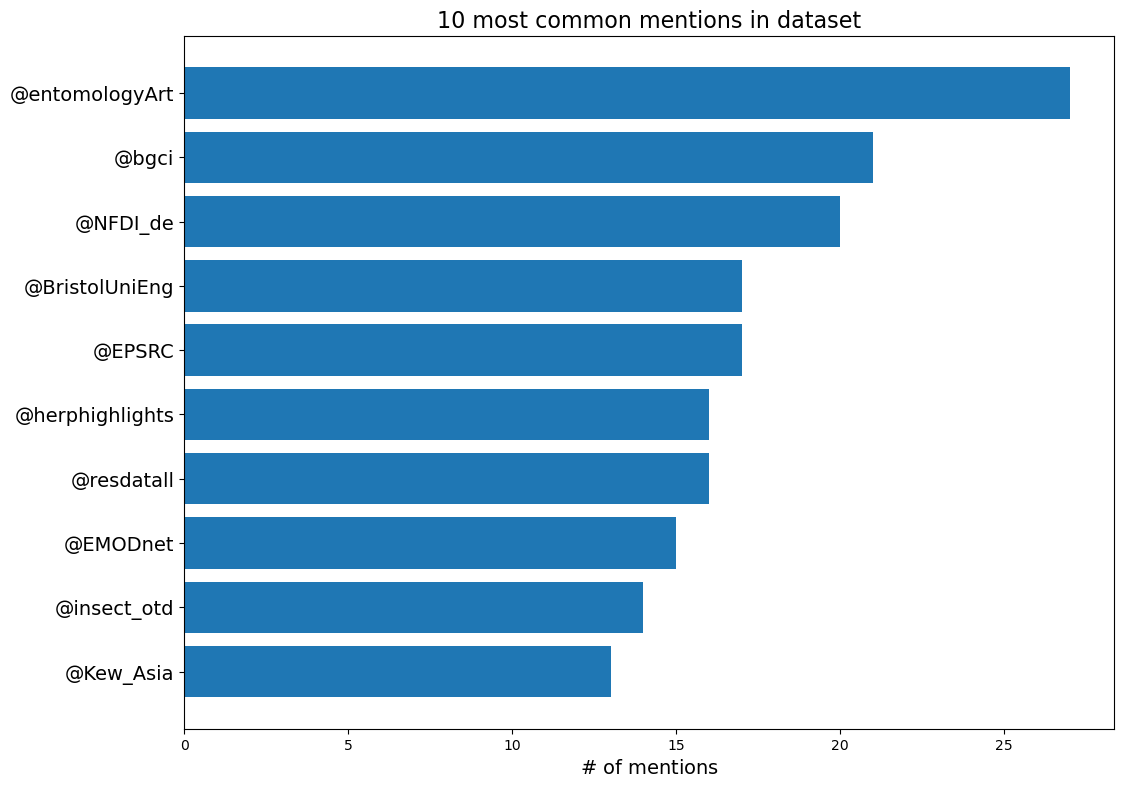

In [29]:
# figure setup
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

# barplot
bar = ax.barh(mentLabels[::-1], mentValues[::-1])

# cosmetics 
yticks = ax.set_yticklabels(mentLabels[::-1], fontdict={'fontsize': 14})

# description
ax.set_title(f"{mostCommon} most common mentions in dataset", fontsize=16)
ax.set_xlabel("$\#$ of mentions", fontdict={'fontsize': 14})

/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_58156/1337058603.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mentLabels, fontdict={'fontsize': 14})


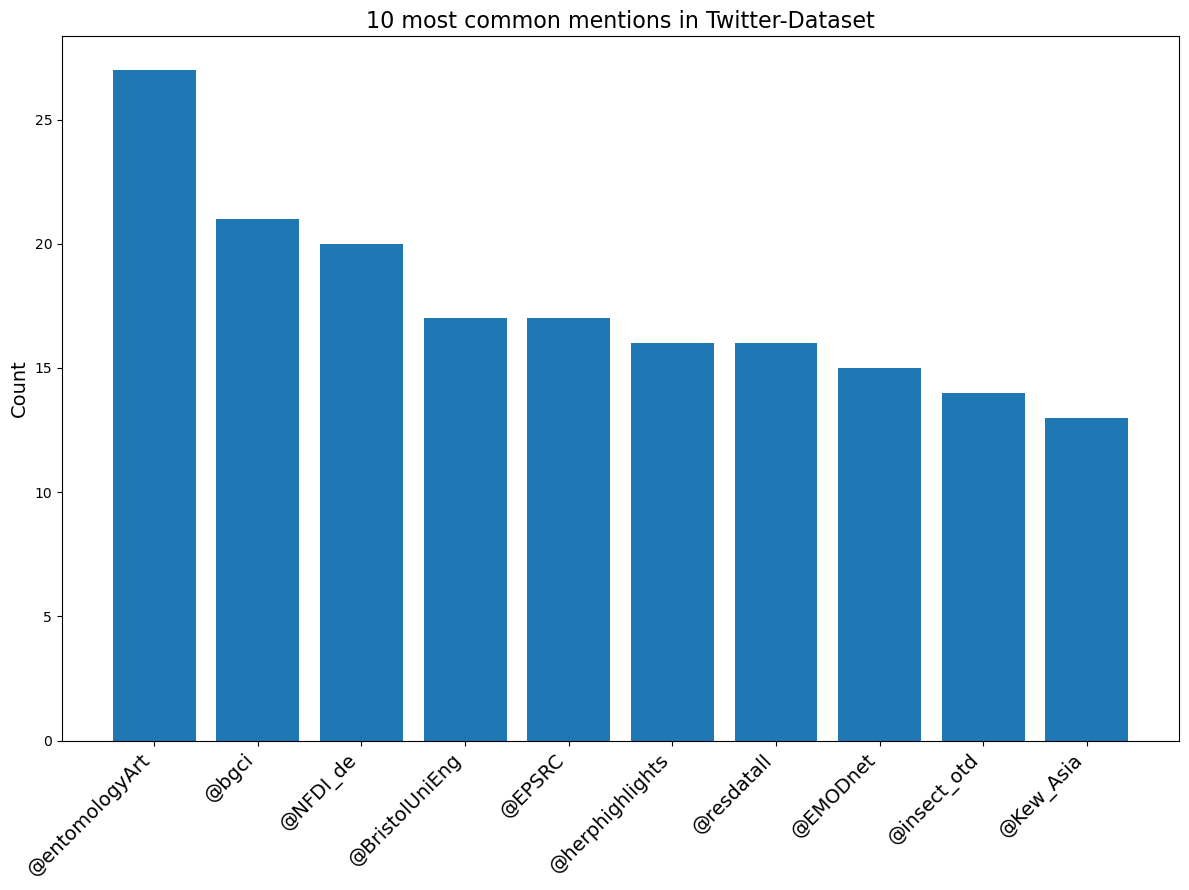

In [6]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

bar = ax.bar(mentLabels, mentValues)

xticks = plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
ax.set_xticklabels(mentLabels, fontdict={'fontsize': 14})

ax.set_title(f"{mostCommon} most common mentions in Twitter-Dataset", fontsize=16)
ax.set_ylabel("Count", fontdict={'fontsize': 14})
fig.tight_layout()
fig.savefig('../results/most_common_mentions_twitter')


## Creating a network graph for the most common participants in

In [7]:
for f, c in zip(data['Username'], data['Content']):
    metas = findMeta(c)
    mentions = metas['@']
    tags = metas['#']
    if inMostCommon([*mentions, f], mentLabels):
        addFollower(twitterGraph, f, mentions)

In [8]:
sizes = {l: v for l, v in zip(mentLabels, mentValues)}
sizesList = [sizes.get(m, 10) for m in twitterGraph.nodes]
printLabels = {n: '' if n not in mentLabels else n for n in twitterGraph.nodes}

In [9]:
plt.figure(figsize=(12, 12))
nx.draw_spring(twitterGraph, node_shape='.', node_size=sizesList, with_labels=True, 
               font_size=12, labels=printLabels, edge_color="#d3d3d3" )
# plt.savefig("testfig.svg")

TypeError: '_AxesStack' object is not callable

<Figure size 1200x1200 with 0 Axes>

Generate Graph structure

(-0.740240418010991,
 0.7283387488847799,
 -1.1892403779305263,
 0.991529691554586)

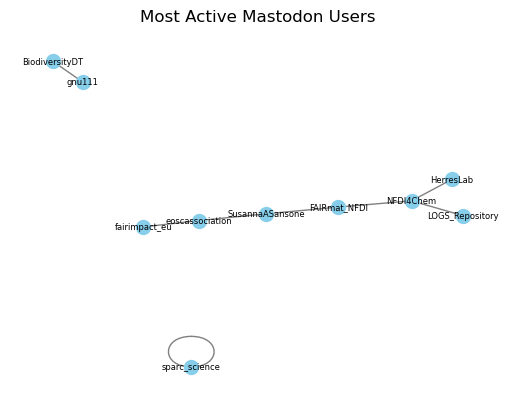

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize the graph
mostActiveTwitterGraph = nx.Graph()

# Find most common posters
mostCommon = 20  # Number of most common posters to consider
posters = data['Username'].value_counts().nlargest(mostCommon).index.tolist()

# Add nodes and edges to the graph
for poster in posters:
    mentions = data[data['Username'] == poster]['Content'].str.findall(r'@(\w+)')
    mention_set = set().union(*mentions)
    for mention in mention_set:
        if mention in posters:
            mostActiveTwitterGraph.add_edge(poster, mention)

# Draw the graph
pos = nx.spring_layout(mostActiveTwitterGraph)  # Compute the layout positions
nx.draw_networkx(mostActiveTwitterGraph, pos=pos, node_color='skyblue', node_size=100, edge_color='gray', with_labels=True, font_size=6)

# Customize the graph layout
plt.title('Most Active Mastodon Users')
plt.axis('off')

#


## concat all mastodon datasets

In [11]:
files = ['../data/mastodon/python_tooswales_toots_fairdata_228.csv', 
         '../data/mastodon/python_tooswales_toots_fairdata_228.csv', 
         '../data/mastodon/python_science_Mastodon_toots_fairdata_205.csv',
        '../data/mastodon/python_nfdi_toots_fairdata_26.csv', 
        '../data/mastodon/python_openbiblio_toots_fairdata_213.csv',
        '../data/mastodon/python_qotoorg_toots_fairdata_342.csv',
         '../data/mastodon/python_Scicommxyz_toots_fairdata_435.csv', 
         '../data/mastodon/python_mstdnscience_toots_fairdata_290.csv', 
         '../data/mastodon/python_newsiesocial_toots_fairdata_41.csv', 
         '../data/mastodon/python_mastodonscot_toots_fairdata_394.csv',
         '../data/mastodon/python_med_mastodon_toots_fairdata_240.csv',
         '../data/mastodon/python_mastodonScienceCom_toots_fairdata_16_06_23_205.csv',
         '../data/mastodon/python_mastodonnz_toots_fairdata_5.csv',
         '../data/mastodon/python_mastodonied_toots_fairdata_319.csv',
         '../data/mastodon/python_mastodongreen_toots_fairdata_438.csv',
         '../data/mastodon/python_mastodongreen_toots_fairdata_438.csv',
         '../data/mastodon/python_mastodonau_toots_fairdata_153.csv',
         '../data/mastodon/python_mastodon_toots_fair-data_160623_500.csv',
         '../data/mastodon/python_homesocial_toots_fairdata_275.csv',
         '../data/mastodon/python_genomic_toots_fairdata_369.csv',
         '../data/mastodon/python_fediscience_toots_fairdata_466.csv',
         '../data/mastodon/python_fairpointssocial_toots_fairdata_70.csv',
         '../data/mastodon/python_ecoevo_toots_fairdata_417.csv',
         '../data/mastodon/python_chaossocial_toots_fairdata_443.csv',
         '../data/mastodon/python_aussocial_toots_fairdata_314.csv',
         '../data/mastodon/python_astrodon_toots_fairdata_137.csv',
         '../data/mastodon/python_appuk_toots_fairdata_392.csv'
        ]


In [12]:
# Empty list to store DataFrames
dataframes = []

for file in files:
    # Read each CSV file into a DataFrame and append it to the list
    dataframes.append(pd.read_csv(file))

# Concatenate all the dataframes in the list into a single DataFrame
df = pd.concat(dataframes, keys=files)


In [13]:
df.shape

(7590, 29)

In [14]:
df.head(10)

Unnamed: 0  \
../data/mastodon/python_tooswales_toots_fairdat... 0           0   
                                                   1           1   
                                                   2           2   
                                                   3           3   
                                                   4           4   
                                                   5           5   
                                                   6           6   
                                                   7           7   
                                                   8           8   
                                                   9           9   

                                                                      id  \
../data/mastodon/python_tooswales_toots_fairdat... 0  110548966831726201   
                                                   1  110547499407785470   
                                                   2  110547331904520997   
                                                   3  110544344595534282   
                                                   4  110525037439900079   
                                                   5  110514525776306970   
                                                   6  110513931459342417   
                                                   7  110513074859534462   
                                                   8  110512813901578105   
                                                   9  110512744394503540   

                                                                    created_at  \
../data/mastodon/python_tooswales_toots_fairdat... 0  2023-06-15T15:36:04.000Z   
                                                   1  2023-06-15T09:22:54.000Z   
                                                   2  2023-06-15T08:40:18.000Z   
                                                   3  2023-06-14T20:00:36.000Z   
                                                   4  2023-06-11T10:10:32.000Z   
                                                   5  2023-06-09T13:37:17.000Z   
                                                   6  2023-06-09T11:06:08.000Z   
                                                   7  2023-06-09T07:28:17.000Z   
                                                   8  2023-06-09T06:21:56.000Z   
                                                   9  2023-06-09T06:04:15.000Z   

                                                      in_reply_to_id  \
../data/mastodon/python_tooswales_toots_fairdat... 0             NaN   
                                                   1             NaN   
                                                   2             NaN   
                                                   3             NaN   
                                                   4             NaN   
                                                   5             NaN   
                                                   6             NaN   
                                                   7             NaN   
                                                   8             NaN   
                                                   9             NaN   

                                                      in_reply_to_account_id  \
../data/mastodon/python_tooswales_toots_fairdat... 0                     NaN   
                                                   1                     NaN   
                                                   2                     NaN   
                                                   3                     NaN   
                                                   4                     NaN   
                                                   5                     NaN   
                                                   6                     NaN   
                                                   7                     NaN   
                                                   8

In [36]:
# init graph
twitterGraph = nx.Graph()

# find most common hashtags and mentions
mostCommonMastodon = 10  # arbitrary
hashtagsMastodon = []  # init
mentionsMastodon = []  # init

for l in df.content:
    metas = findMeta(str(l))
    hashtagsMastodon.extend(metas['#'])
    mentionsMastodon.extend(metas['@'])
mentionsMastodon = [m for m in mentionsMastodon if len(m) > 1 and '<' not in m and m.count('@') == 1] 


hashtagsMastodon = sorted(hashtagsMastodon)
mentionsMastodon = sorted(mentionsMastodon)

hashLabelsMastodon, hashValuesMastodon = occuranceCounter(hashtagsMastodon, mostCommon=mostCommonMastodon)
mentLabelsMastodon, mentValuesMastodon = occuranceCounter(mentionsMastodon, mostCommon=mostCommonMastodon)

/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_58156/3255085834.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mentLabels, fontdict={'fontsize': 14})


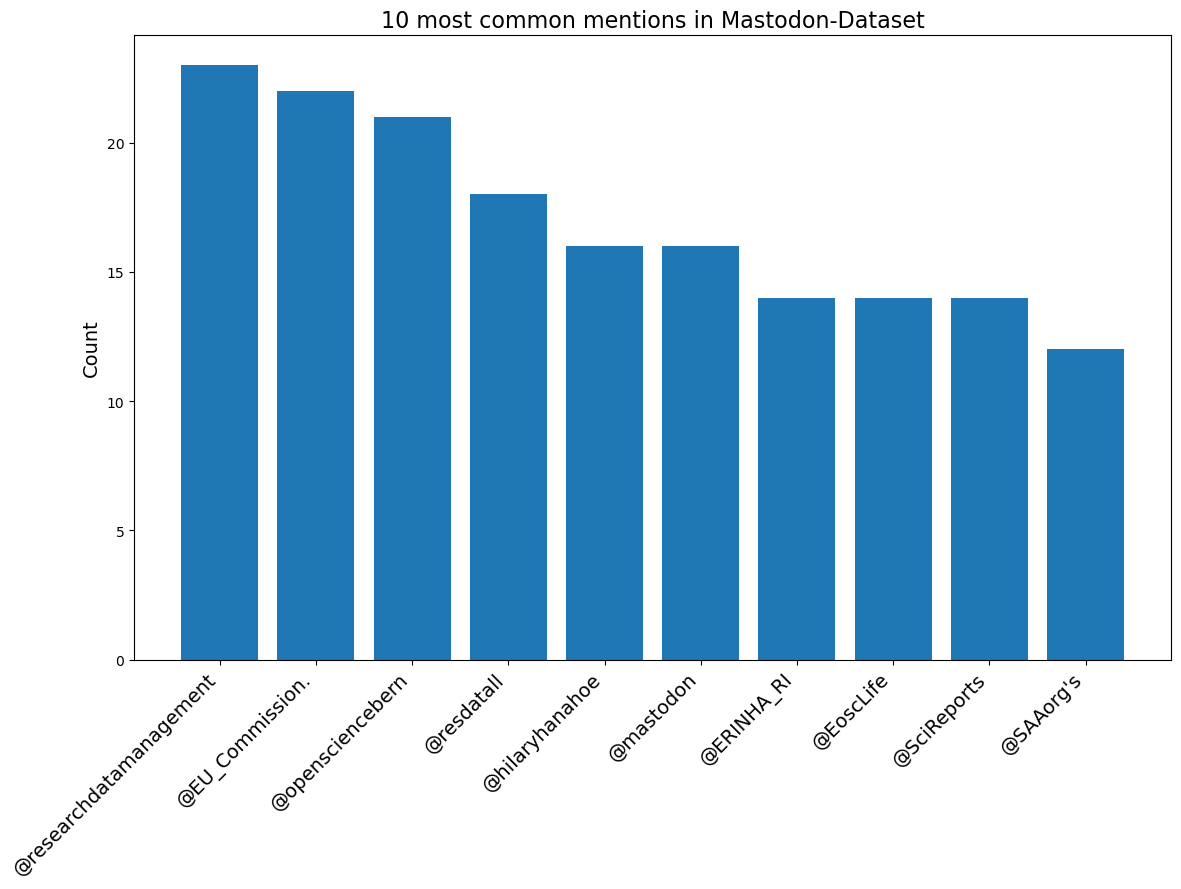

In [16]:
# figure setup
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

# barplot
bar = ax.bar(mentLabels, mentValues)

# cosmetics 
xticks = plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
ax.set_xticklabels(mentLabels, fontdict={'fontsize': 14})

# description
ax.set_title(f"{mostCommon} most common mentions in Mastodon-Dataset", fontsize=16)
ax.set_ylabel("Count", fontdict={'fontsize': 14})
fig.tight_layout()
fig.savefig('../results/most_common_mentions_mastodon2')

/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_58156/4204787558.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  yticks = ax.set_yticklabels(mentLabels[::-1], fontdict={'fontsize': 1})


<Figure size 640x480 with 0 Axes>

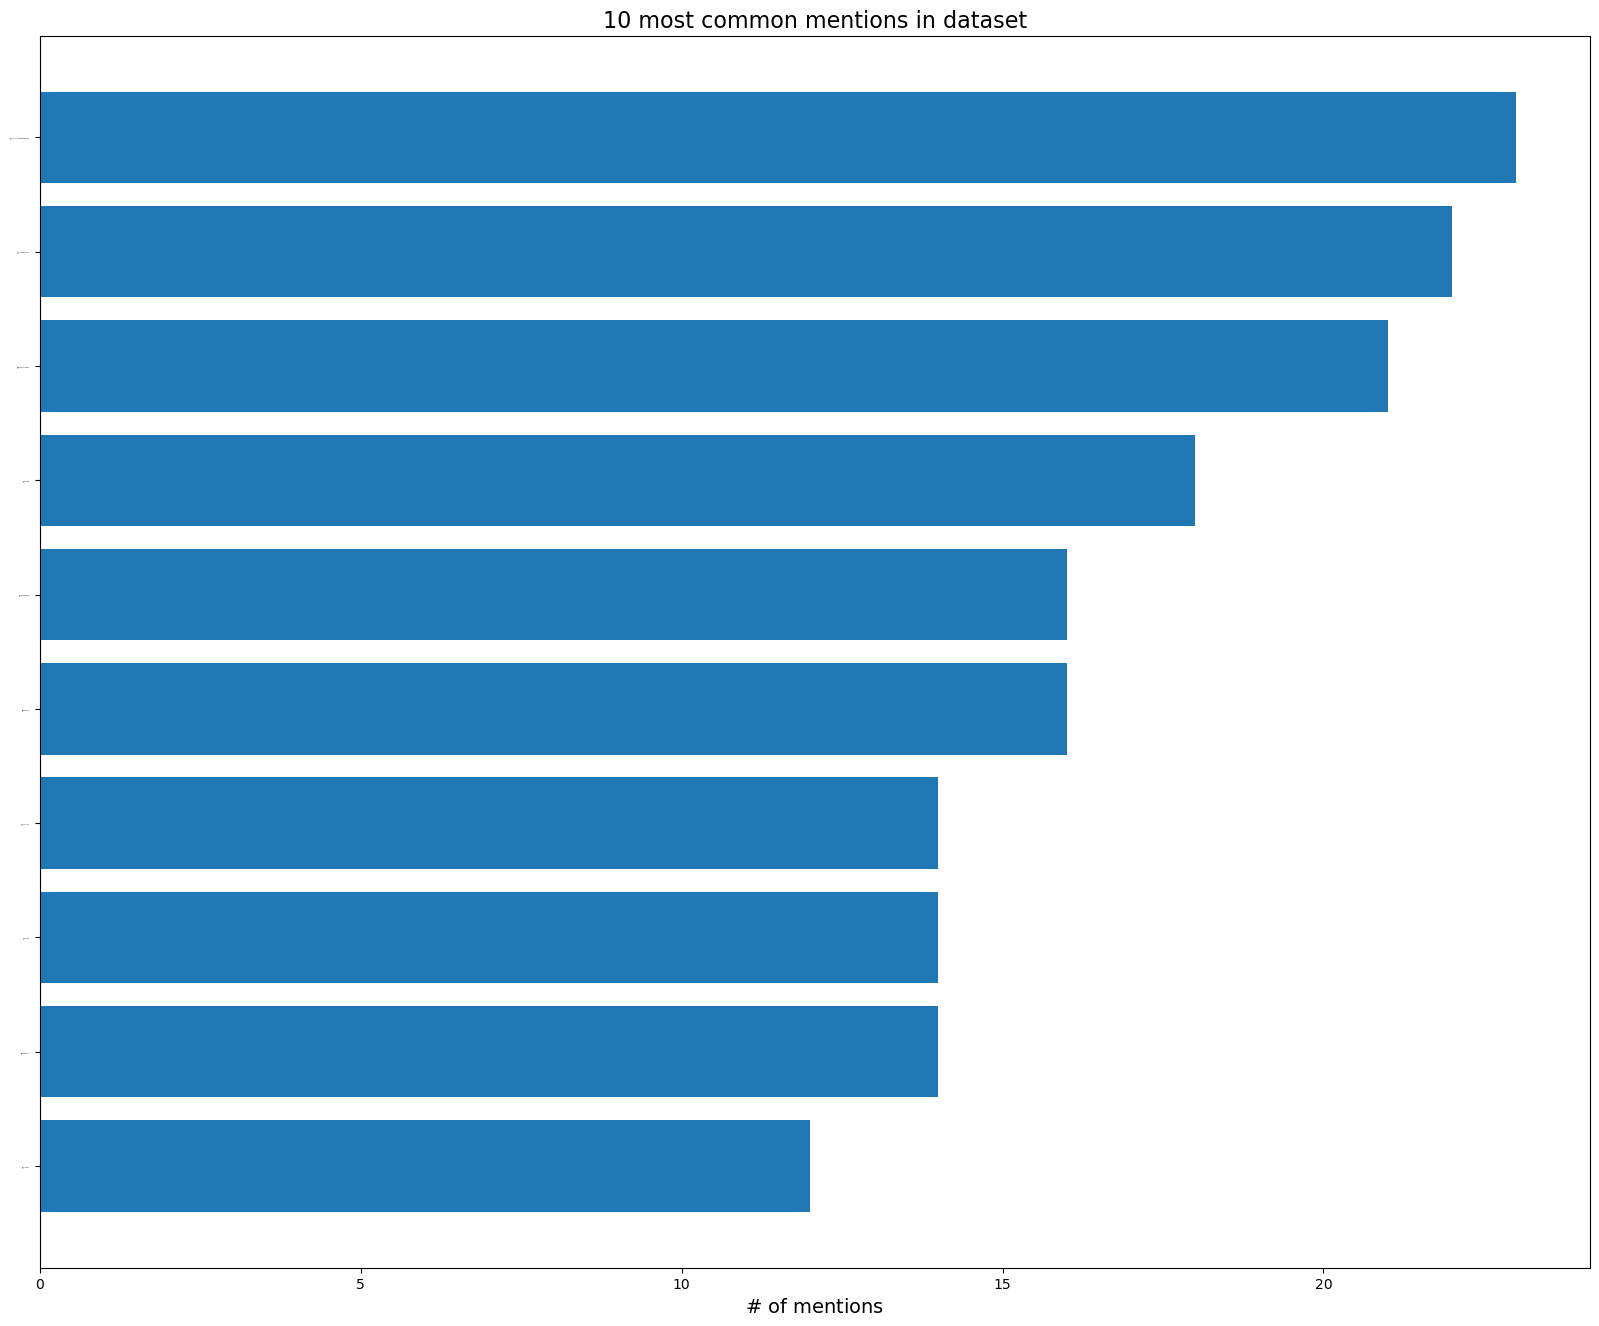

In [17]:
# figure setup
plt.tight_layout()
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)

# barplot
bar = ax.barh(mentLabels[::-1], mentValues[::-1])

# cosmetics 
yticks = ax.set_yticklabels(mentLabels[::-1], fontdict={'fontsize': 1})

# description
ax.set_title(f"{mostCommon} most common mentions in dataset", fontsize=16)
ax.set_xlabel("$\#$ of mentions", fontdict={'fontsize': 14})
plt.savefig('../results/most_common_mentions_mastodon')

In [18]:
for f, c in zip(df['account'], df['content']):
  #  f = f.split('/')[3]  # get the handle
    metas = findMeta(c)
    mentions = metas['@']
    tags = metas['#']
    if inMostCommon([*mentions, f], mentLabels):
        addFollower(twitterGraph, f, mentions)

In [19]:
sizes = {l: v for l, v in zip(mentLabels, mentValues)}
sizesList = [sizes.get(m, 20) for m in twitterGraph.nodes]
printLabels = {n: '' if n not in mentLabels else n for n in twitterGraph.nodes}

In [20]:
plt.figure(figsize=(12, 12))
nx.draw_spring(twitterGraph, node_shape='.', node_size=sizesList, with_labels=True, 
               font_size=12, labels=printLabels, edge_color="#d3d3d3" )
# plt.savefig("testfig.svg")

TypeError: '_AxesStack' object is not callable

<Figure size 1200x1200 with 0 Axes>

In [21]:

pos = nx.spring_layout(twitterGraph, k=10)  # Verändere den k-Wert, um den gewünschten Abstand zu erzielen
nx.draw(twitterGraph, pos, node_shape='.', node_size=sizesList, with_labels=True, 
        font_size=12, labels=printLabels, edge_color="#d3d3d3")

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

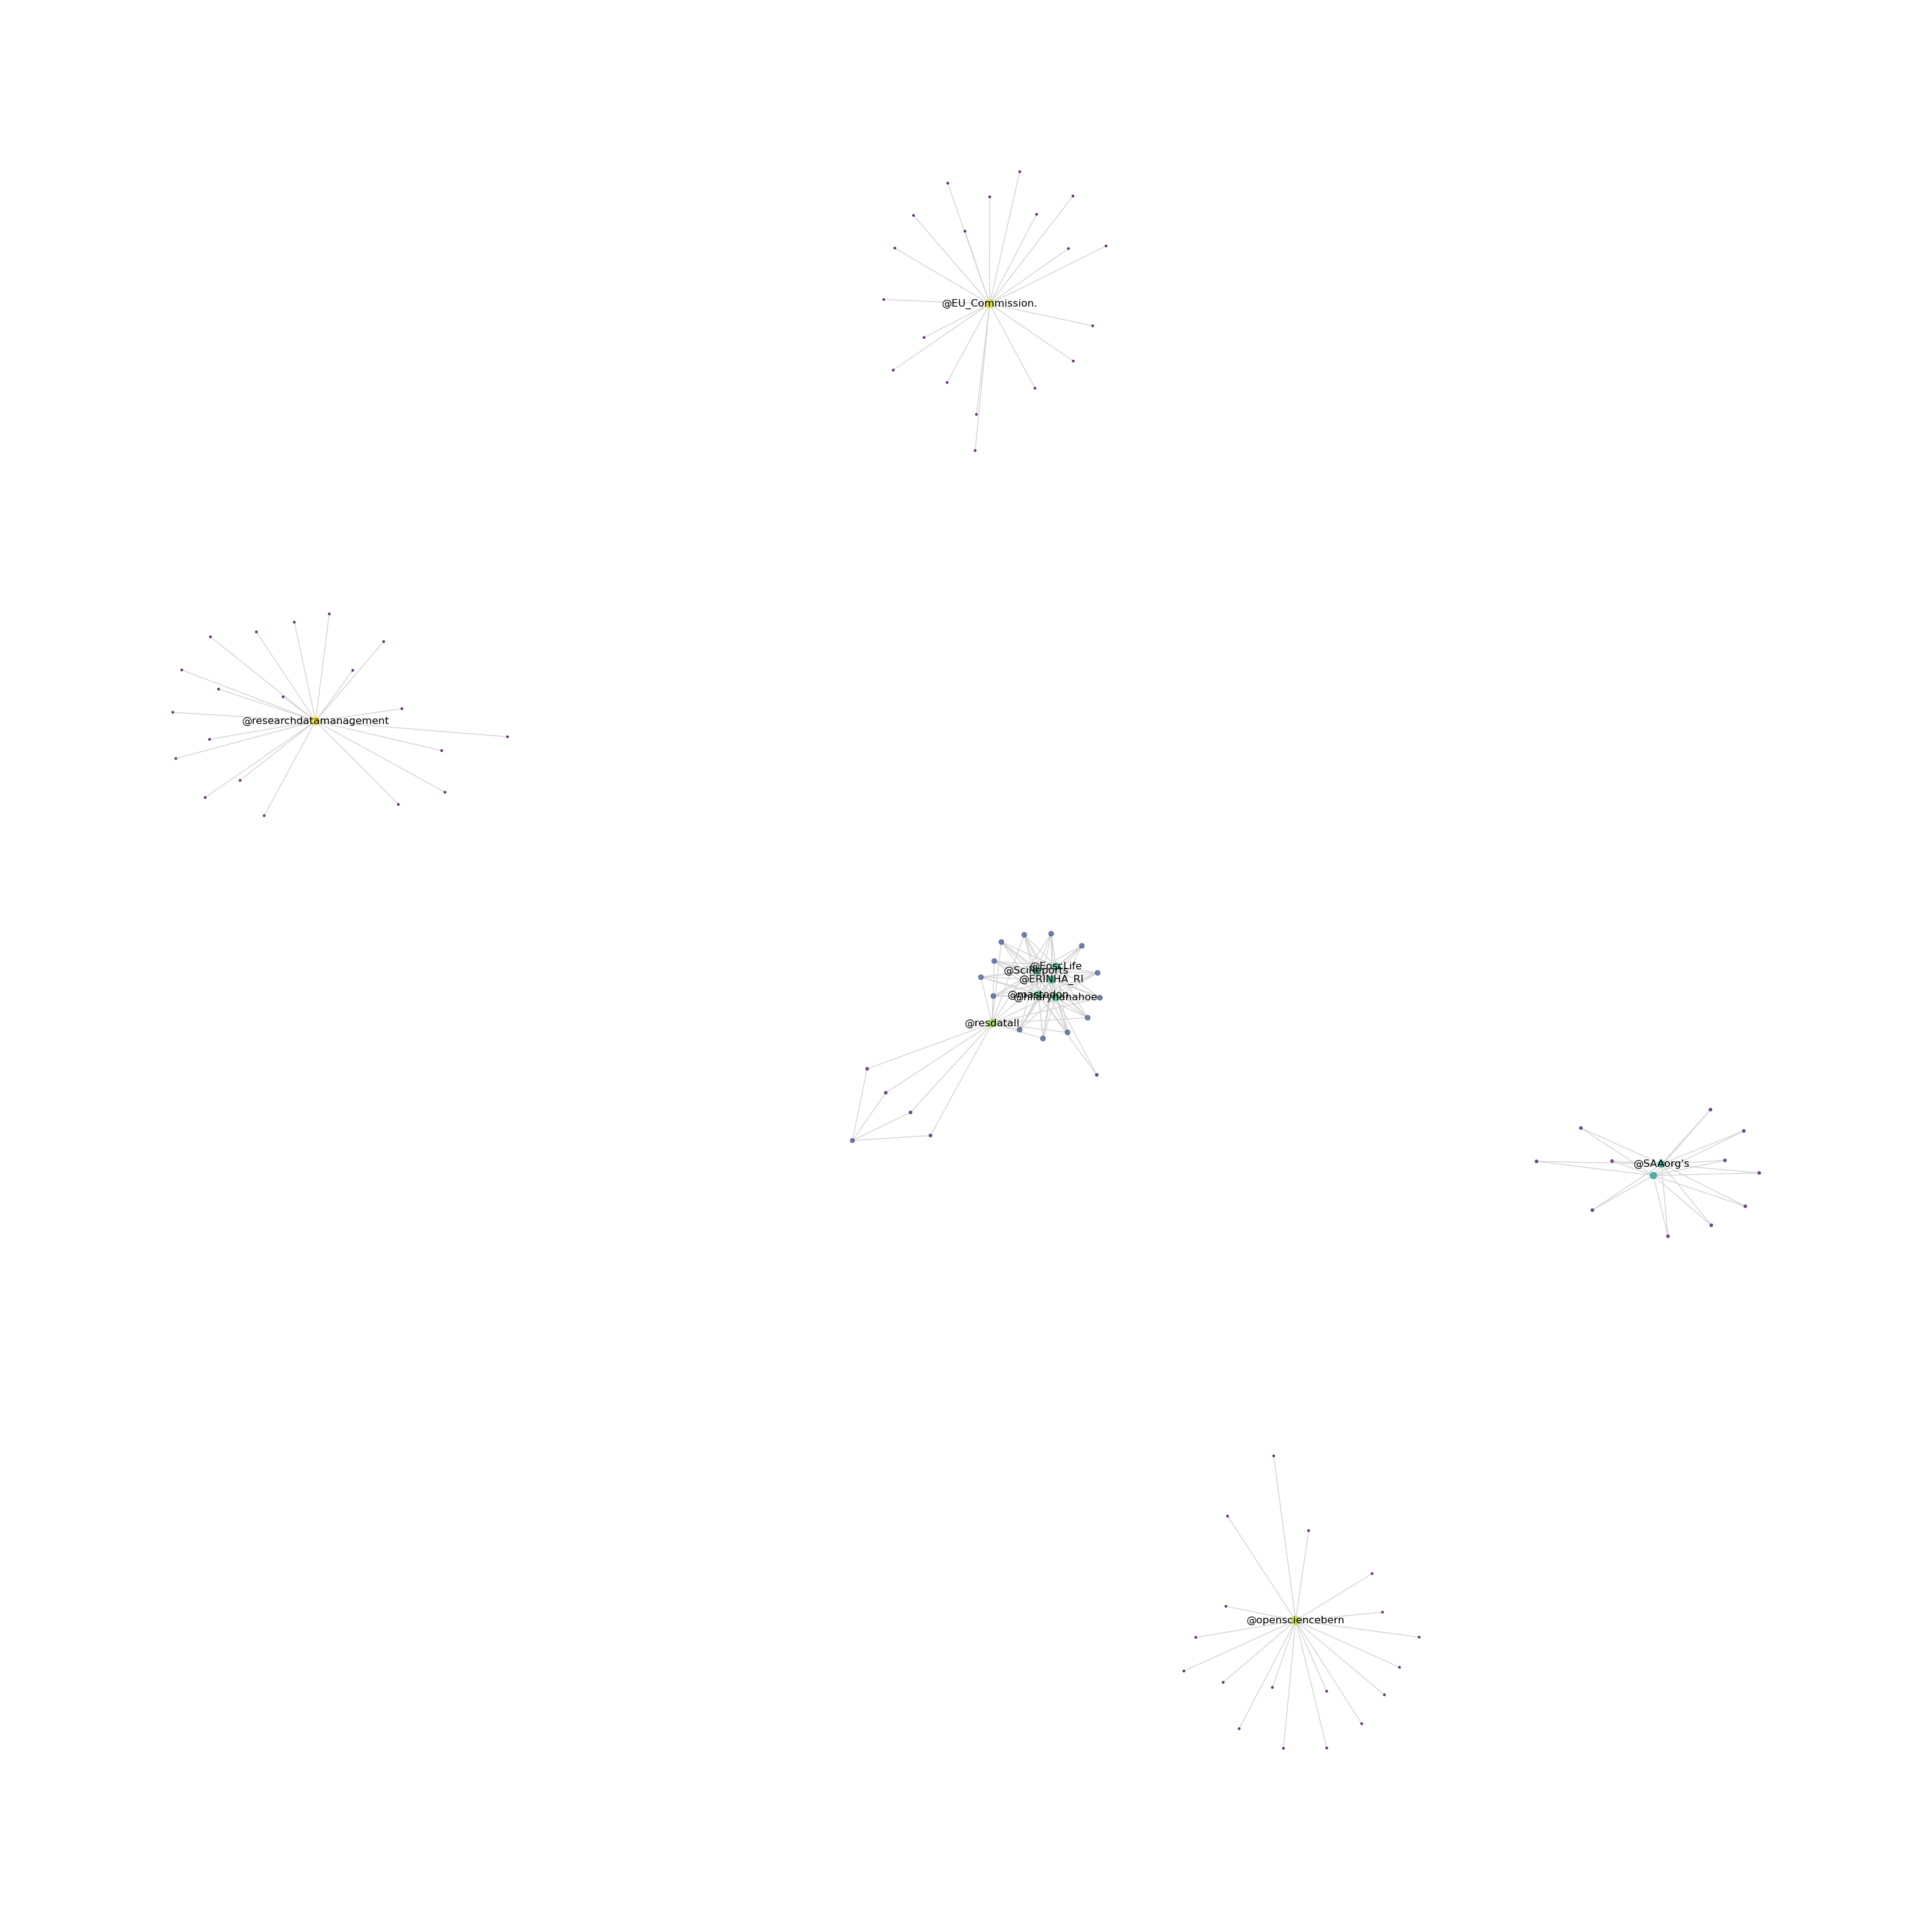

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# Calculate the degree of each node (returns a dictionary)
degrees = dict(nx.degree(twitterGraph))

# Calculate degree centrality of nodes
centrality = nx.degree_centrality(twitterGraph)

# Create a list of degrees which will be used for node size
sizes = [v * 500 for v in centrality.values()]

# Create a list of degrees which will be used for color
colors = [v for v in degrees.values()]

# Labels for nodes with highest centrality
# First, we'll identify the top nodes
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_node_labels = {node: node for node, centrality in top_nodes}

pos = nx.spring_layout(twitterGraph, k=0.15)

plt.figure(figsize=(40, 40))

# Draw nodes
nx.draw_networkx_nodes(twitterGraph, pos, node_size=sizes, node_color=colors, alpha=0.7, cmap='viridis')

# Draw edges
nx.draw_networkx_edges(twitterGraph, pos, edge_color="#d3d3d3")

# Draw labels for top nodes
nx.draw_networkx_labels(twitterGraph, pos, labels=top_node_labels, font_size=12)

plt.axis('off')  # Turn off the axis
plt.savefig('../results/networkgraph')
plt.show()

/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_58156/4046642067.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(mentLabelsMastodon, rotation=45, ha="right")
/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_58156/4046642067.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(mentLabelsTwitter, rotation=45, ha="right")


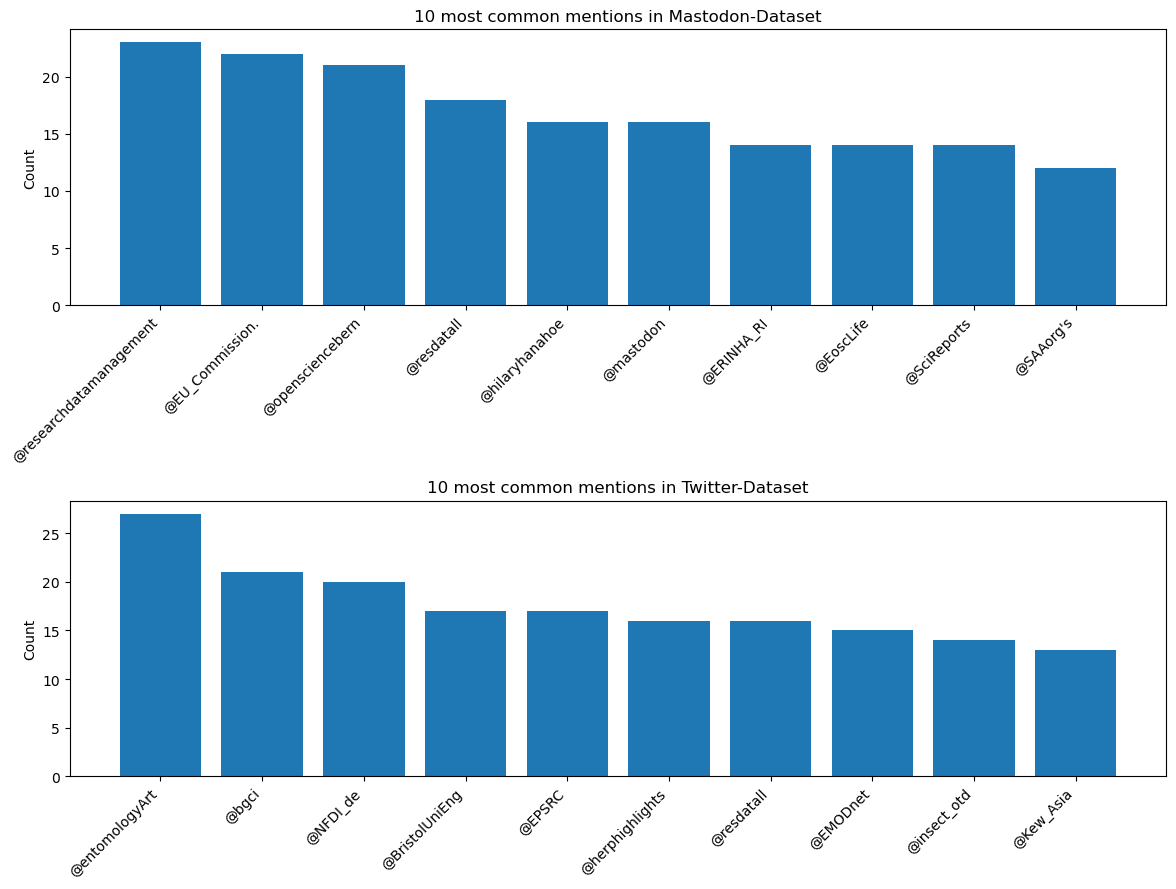

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))

# Barplot for Mastodon dataset
ax1.bar(mentLabelsMastodon, mentValuesMastodon)
ax1.set_title(f"{mostCommonMastodon} most common mentions in Mastodon-Dataset")
ax1.set_ylabel("Count")
ax1.set_xticklabels(mentLabelsMastodon, rotation=45, ha="right")

# Barplot for Twitter dataset
ax2.bar(mentLabelsTwitter, mentValuesTwitter)
ax2.set_title(f"{mostCommontwitter} most common mentions in Twitter-Dataset")
ax2.set_ylabel("Count")
ax2.set_xticklabels(mentLabelsTwitter, rotation=45, ha="right")

fig.tight_layout()

fig.savefig('../results/most_common_mentions_combined')
